In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load users
users = pd.read_csv('./takehome_users.csv', encoding='latin1')

# Load engagement log
engagement = pd.read_csv('./takehome_user_engagement.csv', encoding='latin1')

# Quick overview
print(users.shape)
print(engagement.shape)

(12000, 10)
(207917, 3)


In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
# Convert timestamps
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(
    users['last_session_creation_time'], unit='s'
)

In [6]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [8]:
# Check the user ID is unique
users['object_id'].is_unique

True

In [9]:
# Create a “login_day” Column
engagement['login_day'] = engagement['time_stamp'].dt.date

engagement.head()

,time_stamp,user_id,visited,login_day
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [10]:
# For Each User, Sort Their Login Days

# Drop duplicates: only count unique days
user_daily = engagement[['user_id', 'login_day']].drop_duplicates()

# Sort
user_daily = user_daily.sort_values(['user_id', 'login_day'])
user_daily.head()

,user_id,login_day
0,1,2014-04-22
1,2,2013-11-15
2,2,2013-11-29
3,2,2013-12-09
4,2,2013-12-25


## Define Adopted User

In [11]:
# Define the function
def is_adopted(dates):
    """
    Input: a sorted list of unique login date objects (e.g. [2023-01-01, 2023-01-03, 2023-01-08])
    Output: True if the user logged in 3 or more times within ANY 7-day window
    """

    # If the user has fewer than 3 login days, adoption is impossible
    if len(dates) < 3:
        return False

    # Slide a 7-day window across all login dates
    for i in range(len(dates) - 2):

        # Start of the window = this login date
        start = dates[i]

        # End of the window = 7 days later
        end = start + timedelta(days=7)

        # Count login dates that fall inside this 7-day window
        count = sum(start <= d < end for d in dates)

        # If 3 or more logins fall inside this 7-day window → ADOPTED
        if count >= 3:
            return True

    # If no 7-day window contains 3 logins → NOT adopted
    return False

In [12]:
# Group login days per user
user_group = user_daily.groupby('user_id')['login_day'].apply(list)

# Compute adopted flag
adopted = user_group.apply(is_adopted).reset_index()
adopted.columns = ['user_id', 'adopted']
adopted.head()

,user_id,adopted
0,1,False
1,2,True
2,3,False
3,4,False
4,5,False


In [13]:
# Merge adopted flag into full user table
users = users.merge(adopted, how='left', left_on='object_id', right_on='user_id')

# Users with no logins --> adopted = False
users['adopted'] = users['adopted'].fillna(False)

users[['object_id', 'creation_source', 'adopted']].head()

C:\Users\WEYAN52\AppData\Local\Temp\ipykernel_63932\3373941321.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  users['adopted'] = users['adopted'].fillna(False)


,object_id,creation_source,adopted
0,1,GUEST_INVITE,False
1,2,ORG_INVITE,True
2,3,ORG_INVITE,False
3,4,GUEST_INVITE,False
4,5,GUEST_INVITE,False


In [14]:
# Check Overall Adoption Rate
adoption_rate = users['adopted'].mean()
adoption_rate

np.float64(0.1335)

## EDA on User Characteristics

Adoption rate by signup source:
creation_source
SIGNUP_GOOGLE_AUTH    0.167509
GUEST_INVITE          0.166436
SIGNUP                0.140393
ORG_INVITE            0.129995
PERSONAL_PROJECTS     0.077688
Name: adopted, dtype: float64


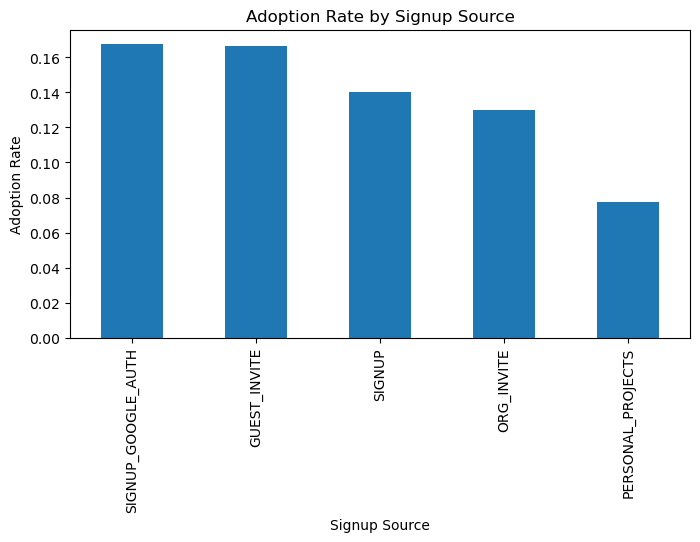

In [15]:
# Compare adoption rate across signup sources

signup_adoption = users.groupby('creation_source')['adopted'].mean().sort_values(ascending=False)

print("Adoption rate by signup source:")
print(signup_adoption)

signup_adoption.plot(kind='bar', figsize=(8,4))
plt.title("Adoption Rate by Signup Source")
plt.ylabel("Adoption Rate")
plt.xlabel("Signup Source")
plt.show()

In [16]:
# Prepare summary table
signup_count = users['creation_source'].value_counts()

signup_summary = pd.DataFrame({
    'count': users['creation_source'].value_counts(),
    'adoption_rate': users.groupby('creation_source')['adopted'].mean()
}).sort_values('count', ascending=False)

signup_summary.head()

,count,adoption_rate
creation_source,,
ORG_INVITE,4254,0.129995
GUEST_INVITE,2163,0.166436
PERSONAL_PROJECTS,2111,0.077688
SIGNUP,2087,0.140393
SIGNUP_GOOGLE_AUTH,1385,0.167509


In [17]:
# Create invited/not_invited flag
# NaN → user was NOT invited; has a number → user was invited by someone
users['invited_flag'] = users['invited_by_user_id'].notnull()

users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted,invited_flag
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1.0,False,True
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2.0,True,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,3.0,False,True
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,4.0,False,True
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5.0,False,True


### Invited vs. Not Invited

In [18]:
# Adoption rate by invited flag
inv_summary = users.groupby('invited_flag')['adopted'].mean()
inv_count = users['invited_flag'].value_counts()

print("User count:")
print(inv_count)
print("\nAdoption rate:")
print(inv_summary)

User count:
invited_flag
True     6417
False    5583
Name: count, dtype: int64

Adoption rate:
invited_flag
False    0.123410
True     0.142278
Name: adopted, dtype: float64


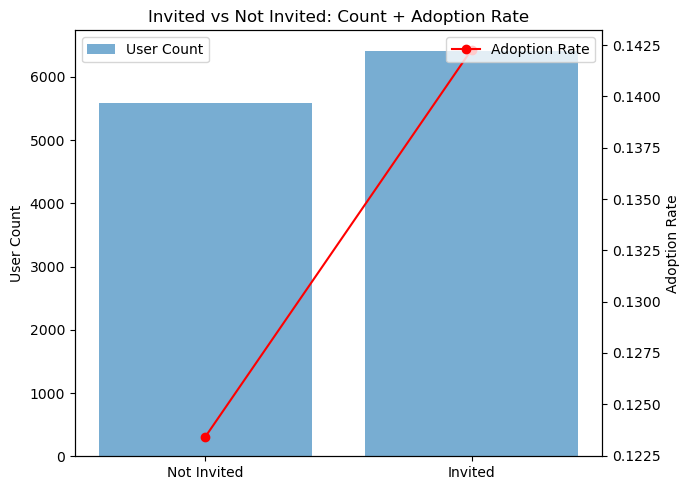

In [19]:
# Combined plot: user count + adoption rate
inv_data = pd.DataFrame({
    'count': users['invited_flag'].value_counts(),
    'adoption_rate': users.groupby('invited_flag')['adopted'].mean()
}).sort_index()

fig, ax1 = plt.subplots(figsize=(7,5))

# Bar for counts
ax1.bar(['Not Invited', 'Invited'], inv_data['count'], alpha=0.6, label='User Count')
ax1.set_ylabel('User Count')

# Line for adoption rate
ax2 = ax1.twinx()
ax2.plot(['Not Invited', 'Invited'], inv_data['adoption_rate'], 
         marker='o', color='red', label='Adoption Rate')
ax2.set_ylabel('Adoption Rate')

plt.title("Invited vs Not Invited: Count + Adoption Rate")

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Organization-Level Effects

In [20]:
# Count users per organization
org_size = users.groupby('org_id')['object_id'].count().rename('org_size')

# Merge org_size back into users table
users = users.merge(org_size, on='org_id', how='left')

users[['org_id', 'org_size']].head()

,org_id,org_size
0,11,75
1,1,233
2,94,32
3,1,233
4,193,16


In [21]:
# Relationship: org size vs adoption
org_adoption = users.groupby('org_size')['adopted'].mean()
org_adoption.head()

org_size
2     0.000000
7     0.142857
8     0.250000
9     0.111111
10    0.200000
Name: adopted, dtype: float64

In [22]:
# Create size buckets
users['org_size_bucket'] = pd.cut(
    users['org_size'],
    bins=[0, 5, 20, 50, 200, 10000],
    labels=['1–5', '6–20', '21–50', '51–200', '200+']
)

In [23]:
# Adoption rate by bucket
bucket_adoption = users.groupby('org_size_bucket')['adopted'].mean()
bucket_count = users['org_size_bucket'].value_counts().sort_index()

print(bucket_adoption)
print(bucket_count)


org_size_bucket
1–5       0.000000
6–20      0.165156
21–50     0.140579
51–200    0.103724
200+      0.053121
Name: adopted, dtype: float64
org_size_bucket
1–5          2
6–20      2979
21–50     5769
51–200    2497
200+       753
Name: count, dtype: int64


C:\Users\WEYAN52\AppData\Local\Temp\ipykernel_63932\44281806.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_adoption = users.groupby('org_size_bucket')['adopted'].mean()


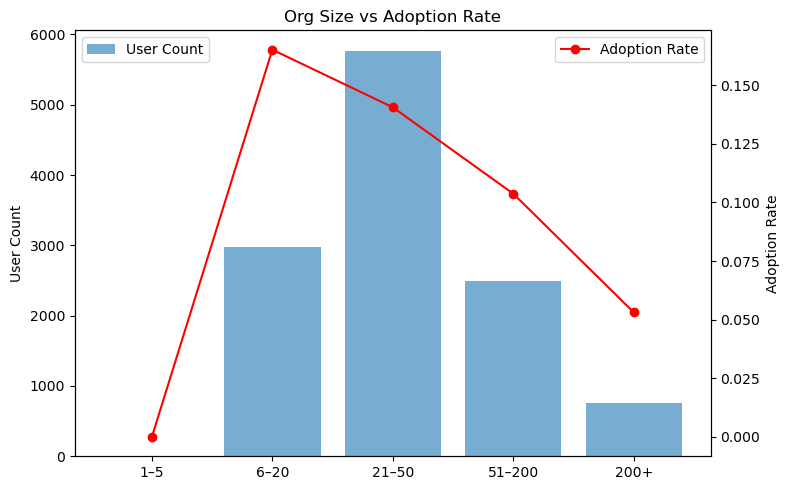

In [24]:
# Plot: org size vs adoption rate
fig, ax1 = plt.subplots(figsize=(8,5))

# Bar chart = count of users
ax1.bar(bucket_count.index, bucket_count.values, alpha=0.6, label="User Count")
ax1.set_ylabel("User Count")

# Line chart = adoption rate
ax2 = ax1.twinx()
ax2.plot(bucket_adoption.index, bucket_adoption.values, 
         marker='o', color='red', label="Adoption Rate")
ax2.set_ylabel("Adoption Rate")

plt.title("Org Size vs Adoption Rate")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

### Marketing Effects

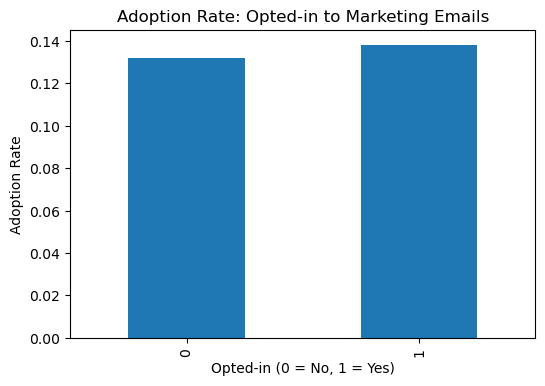

In [25]:
# Adoption rate by mailing opt-in
mail_opt = users.groupby('opted_in_to_mailing_list')['adopted'].mean()

mail_opt.plot(kind='bar', figsize=(6,4))
plt.title("Adoption Rate: Opted-in to Marketing Emails")
plt.xlabel("Opted-in (0 = No, 1 = Yes)")
plt.ylabel("Adoption Rate")
plt.show()

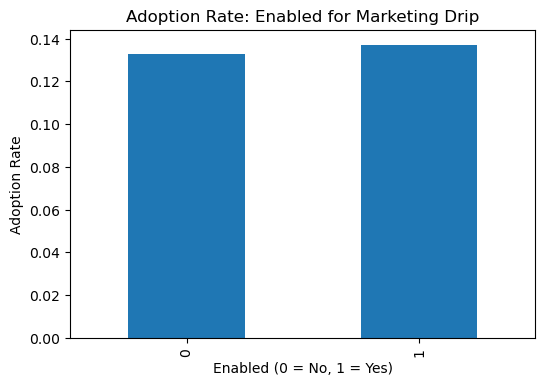

In [26]:
# Adoption rate by marketing drip
drip_opt = users.groupby('enabled_for_marketing_drip')['adopted'].mean()

drip_opt.plot(kind='bar', figsize=(6,4))
plt.title("Adoption Rate: Enabled for Marketing Drip")
plt.xlabel("Enabled (0 = No, 1 = Yes)")
plt.ylabel("Adoption Rate")
plt.show()

### Recency Effects (last_session_creation_time)

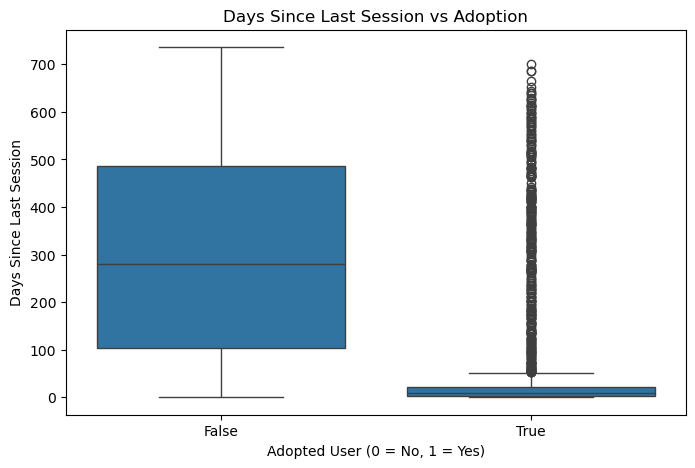

In [27]:
# find the “max” login date in the system
max_date = users['last_session_creation_time'].max()

# 0 days → recently active; big number → long inactive
users['days_since_last_session'] = (max_date - users['last_session_creation_time']).dt.days

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x=users['adopted'], y=users['days_since_last_session'])
plt.title("Days Since Last Session vs Adoption")
plt.xlabel("Adopted User (0 = No, 1 = Yes)")
plt.ylabel("Days Since Last Session")
plt.show()

## Feature Engineering.

### Select Only Relevant Columns:

-- NOT want:

- name

- email

- timestamps in raw format

- invited_by_user_id (we use invited_flag instead)

- creation_time

- last_session_creation_time (we use recency instead)

-- DO want:

1. categorical:

- creation_source

- invited_flag

- org_size_bucket (or org_size numeric)

2. numeric:

- org_size

- days_since_last_session

3. target:

- adopted

In [28]:
model_df = users[[
    'creation_source',
    'invited_flag',
    'org_size',
    'days_since_last_session',
    'opted_in_to_mailing_list',
    'enabled_for_marketing_drip',
    'adopted'
]].copy()

model_df.head()

,creation_source,invited_flag,org_size,days_since_last_session,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted
0,GUEST_INVITE,True,75,45.0,1,0,False
1,ORG_INVITE,True,233,67.0,0,0,True
2,ORG_INVITE,True,32,443.0,0,0,False
3,GUEST_INVITE,True,233,380.0,0,0,False
4,GUEST_INVITE,True,16,500.0,0,0,False


In [29]:
# Check missing values in the modeling dataset
model_df.isna().sum()

creation_source                  0
invited_flag                     0
org_size                         0
days_since_last_session       3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
adopted                          0
dtype: int64

In [30]:
# Missing percentage
(model_df.isna().sum() / len(model_df) * 100).round(2)

creation_source                0.00
invited_flag                   0.00
org_size                       0.00
days_since_last_session       26.48
opted_in_to_mailing_list       0.00
enabled_for_marketing_drip     0.00
adopted                        0.00
dtype: float64

In [31]:
# Fix NaN values
max_recency = model_df['days_since_last_session'].max()

model_df['days_since_last_session'] = \
    model_df['days_since_last_session'].fillna(max_recency)

In [32]:
# Dummy encode creation_source
model_df = pd.get_dummies(
    model_df,
    columns=['creation_source'],
    drop_first=True,
    dtype=int           # forces output to integer
)

In [33]:
X = model_df.drop('adopted', axis=1)
y = model_df['adopted']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9000, 9)
(3000, 9)
(9000,)
(3000,)


In [34]:
X_train.head()

,invited_flag,org_size,days_since_last_session,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
1298,False,42,82.0,0,0,0,1,0,0
2574,False,9,534.0,0,0,0,1,0,0
4138,False,20,736.0,0,0,0,1,0,0
2111,True,36,8.0,0,0,0,0,0,0
11992,False,18,736.0,0,0,0,1,0,0


## Modeling (Logistic Regression)

In [35]:
# Scale Numeric Features: Logistic regression works better when large numeric features (like org_size, days_since) are scaled.

numeric_cols = ['org_size', 'days_since_last_session']
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [36]:
# Fit Logistic Regression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [37]:
# Evaluate Model

y_pred = log_reg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8813333333333333

Classification Report:
              precision    recall  f1-score   support

       False       0.88      1.00      0.94      2600
        True       0.82      0.14      0.24       400

    accuracy                           0.88      3000
   macro avg       0.85      0.57      0.59      3000
weighted avg       0.87      0.88      0.84      3000



In [38]:
# Feature Importance (Coefficients)
coef = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coefficient': log_reg.coef_[0]
}).sort_values('coefficient', ascending=False)

coef

,feature,coefficient
3,opted_in_to_mailing_list,0.028863
4,enabled_for_marketing_drip,-0.079821
5,creation_source_ORG_INVITE,-0.250624
1,org_size,-0.281299
0,invited_flag,-0.414510
6,creation_source_PERSONAL_PROJECTS,-0.503940
8,creation_source_SIGNUP_GOOGLE_AUTH,-0.790510
7,creation_source_SIGNUP,-0.829502
2,days_since_last_session,-2.271003


### Observations from the output:

Accuracy = 0.88
This is high, but accuracy is misleading because the dataset is imbalanced
(2,600 non-adopted vs 400 adopted).

Precision for True (adopted users) = 0.82
→ When the model predicts someone will adopt, it’s often right.

Recall for True = 0.14
→ The model captures only 14% of true adopted users.

### Why is recall low?

Adopted users are only ~14% of the population.

Logistic Regression is linear and struggles to separate a nonlinear pattern.

Most adopted users have “recent login” and specific patterns that a linear model can’t fully capture.

### The REAL Strong Predictor:

Logistic regression shows that recency of activity (days_since_last_session) is by far the strongest predictor of adoption, followed by invitation status and organization size. Signup method also plays a significant role, with self-signups (SIGNUP, SIGNUP_GOOGLE_AUTH) showing the lowest likelihood of adoption. Marketing variables (email opt-in, drip campaigns) show minimal predictive value.

## Modeling (Random Forest Classifier)

In [39]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced'   # important for imbalanced data
)

rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.9106666666666666

Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.96      0.95      2600
        True       0.70      0.57      0.63       400

    accuracy                           0.91      3000
   macro avg       0.82      0.77      0.79      3000
weighted avg       0.90      0.91      0.91      3000



In [40]:
rf_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

rf_importance

,feature,importance
2,days_since_last_session,0.770990
1,org_size,0.183178
3,opted_in_to_mailing_list,0.010357
4,enabled_for_marketing_drip,0.008992
6,creation_source_PERSONAL_PROJECTS,0.007526
5,creation_source_ORG_INVITE,0.007219
0,invited_flag,0.004278
7,creation_source_SIGNUP,0.003927
8,creation_source_SIGNUP_GOOGLE_AUTH,0.003533


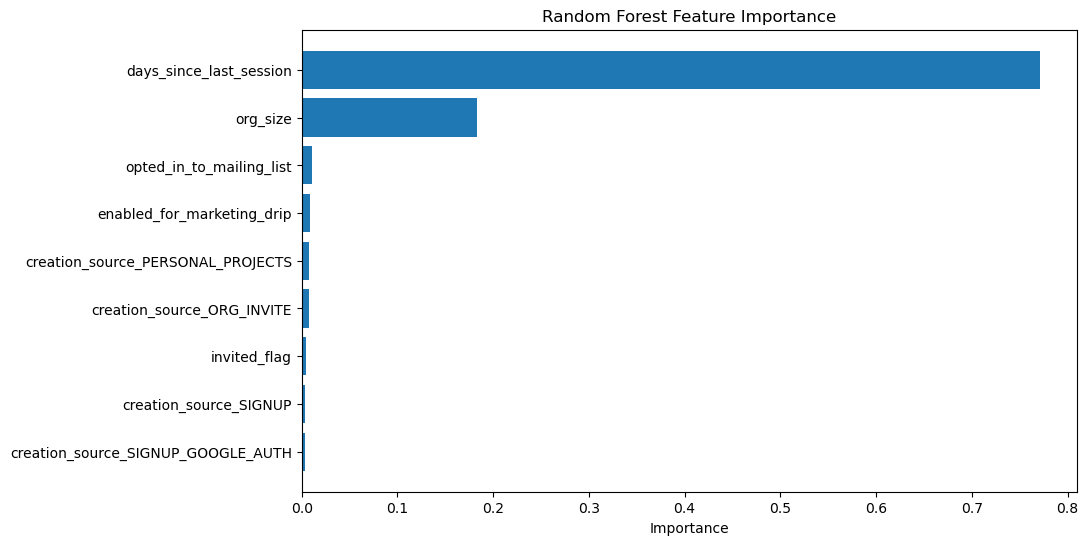

In [41]:
plt.figure(figsize=(10,6))
plt.barh(rf_importance['feature'], rf_importance['importance'])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.show()

User adoption is primarily driven by behavioral and organizational factors rather than marketing or signup channel.
Recent activity (days since last session) and organization size are the strongest predictors of adoption by a large margin.
Signup method and marketing flags show only minor influence.

## FINAL CONCLUSION

User adoption is driven primarily by behavioral and organizational factors, not by marketing or signup method. The analysis shows:

- Recent activity is by far the strongest driver of adoption.

- Organization size has a nonlinear effect: adoption is highest in small-to-medium-sized teams (6–50 users), while very small and very large organizations adopt less.

- Invitation status, signup channel, and marketing opt-ins have minimal predictive impact compared to behavioral signals.

These findings suggest that adoption efforts should focus on:

- Improving early product activation (helping users experience value quickly)

- Driving users back into the product soon after signup (recency is critical)

- Encouraging team-based usage and collaboration, especially helping small teams grow toward the 6–50 user range, where adoption is strongest

- Rather than relying on marketing emails or signup flow tweaks, emphasize in-product engagement and team workflows